<a href="https://colab.research.google.com/github/rohitr02/Twitter-Data-Sentiment-Analysis/blob/main/Twitter%20Sentiment%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
%matplotlib inline

import csv
import copy
import matplotlib 
import matplotlib.pyplot as plt
import numpy as np
import random

def set_seed(seed):  # For reproducibility, fix random seeds.
  random.seed(seed)
  np.random.seed(seed)

The SVM learning problem is a convex optimization problem. It is presented either in its primal or dual form. The primal form is one of norm minimization subject to constraints, while the dual is a quadratic programming problem that is typically solved with an off-the-shelf QP solver. As a result, most popular machine learning libraries (e.g., LIBSVM underneath sklearn) solve the dual. In this assignment, you will solve the primal using subgradient descent, both the simple linear version and a version that supports nonlinear kernels. That is, we will solve the following optimization problem (we're not learning a separate bias weight $b$ without loss of generality):
$$
	w^* = \arg\!\min_{w \in \mathbb{R}^d}\;\; \frac{\lambda}{2} ||w||^2 + \frac{1}{N} \sum_{i=1}^N [\, 1 -  y_i(w \cdot x_i) \,]_+
$$
where $(x_1, y_1) \ldots (x_N, y_N) \in \mathbb{R}^d \times \{ \pm 1 \}$ is training data and $[\cdot]_+ = \max(0, \cdot)$.

# Synthetic Data

To facilitate development, let's start by writing a class that represents a synthetic binary classification dataset. 

In [31]:
class Data: 
  """Parent class for data objects"""
  
  def generate_batch(self, batch_size, shuffle=True):
    inds = list(range(self.num_examples))
    if shuffle:
      random.shuffle(inds)    
    for i in range(0, len(inds), batch_size):
        inds_batch = inds[i: i + batch_size]
        X = self.inputs[inds_batch, :]
        y = self.labels[inds_batch] 
        yield X, y, inds_batch

In [32]:
class Data2D(Data):
  
  def __init__(self, num_examples, boundary='line', input_min=-0.5, input_max=0.5):
    super().__init__()
    set_seed(42)
    self.inputs = np.random.uniform(input_min, input_max, (num_examples, 2))
    if boundary == 'line':
      labels = self.inputs.sum(axis=1) > 0
    elif boundary == 'circle':
      labels = (self.inputs ** 2).sum(axis=1) > ((input_max * 0.7) ** 2)
    else:
      raise ValueError('Unknown boundary: ' + boundary)

    self.labels = 2 * labels - 1  # Convert binary labels from 0/1 to +1/-1    
    self.num_examples = num_examples
    self.dim = 2
    self.input_min = input_min
    self.input_max = input_max

  def plot(self):
    plt.scatter(self.inputs[:, 0], self.inputs[:, 1], c=self.labels, cmap=matplotlib.cm.Paired)
    plt.plot()  

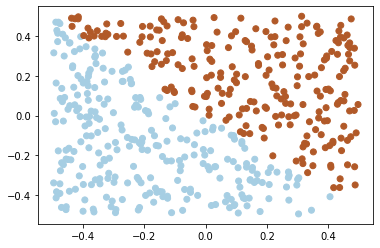

In [33]:
# Dataset of random points on the plane with true labels from a linear decision boundary
data_linear = Data2D(500, boundary='line') 
data_linear.plot()

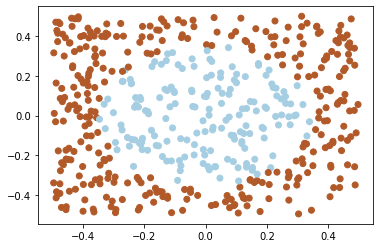

In [34]:
# Dataset of random points on the plane with true labels from a nonlinear decision boundary
data_nonlinear = Data2D(500, boundary='circle')   
data_nonlinear.plot()

# Linear SVM

Implement the linear SVM class below.

In [35]:
class LinearSVM:

  def __init__(self, dim, init_randn=False):
    self.w = np.random.randn(dim) if init_randn else np.zeros(dim) 

  def forward(self, X, y=None, la=1.):
    """
    Given input vectors X (N x d), make N predictions (scores & labels).
    If also given gold labels y, compute the loss/gradient.
    Use regularization strength la ("lambda").
    """ 
    scores = X.dot(self.w[:, np.newaxis]).squeeze() 
    preds = 2 * (scores > 0) - 1  
    loss = None
    grad = None

    if y is not None:
      # margins = None  # TODO: Compute the margins here.
      margins = 1 - y*scores
      margins[margins < 0] = 0  
      loss = np.sum(margins) / X.shape[0]
      loss += 0.5 * la * np.linalg.norm(self.w) * np.linalg.norm(self.w)
      
      # TODO: Use the margins to calculate the loss and the gradient here.
      grad = np.zeros(len(self.w))
      grad += len(margins) * la * self.w
      for i in np.nonzero(margins > 0)[0]:
        grad -= y[i] * X[i]

      grad = grad/len(y)  # average
     
    return {'preds': preds, 'scores': scores, 'loss': loss, 'grad': grad}

To help you check for correctness, the following unit test checks the output of your model against the output of the reference code. 

In [36]:
import unittest

class TestLinearSVM(unittest.TestCase):

  def setUp(self):
    set_seed(42)
    dim = 3
    num_examples = 42
    self.model = LinearSVM(dim, init_randn=True)  # Random init, instead of 0
    self.X = np.random.randn(num_examples, dim)
    self.y = 2 * np.random.randint(2, size=(num_examples,)) - 1
    self.places = 4
      
  def test_model(self): 
    output = self.model.forward(self.X, self.y, 0.01)
    true_loss = 1.2042458946313077  #-0.24501151815868508
    true_grad = [0.16616191, -0.08949146,  0.24762397]
    self.assertAlmostEqual(output['loss'], true_loss, places=self.places)
    for i in range(len(true_grad)):
      self.assertAlmostEqual(output['grad'][i], true_grad[i], places=self.places)
            
unittest.main(TestLinearSVM(), argv=[''], verbosity=2, exit=False)

test_model (__main__.TestLinearSVM) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.003s

OK


## Training

Evaluation function to compute classification accuracy.

In [37]:
def evaluate(model, data, batch_size_eval=16):
  num_correct = 0
  for (X, y, _) in data.generate_batch(batch_size_eval, shuffle=False):
    output = model.forward(X)
    num_correct += (y == output['preds']).sum()
  acc = num_correct / data.num_examples * 100.
  return acc

To train the model, we will use stochastic gradient descent (SGD) with batch size 1. In particular, we will use a dynamic learning rate schedule that sets the learning rate for update $t \geq 1$ as 
$$
\eta_t = \frac{1}{\lambda t}
$$
Recall that $\lambda > 0$ is the regularization hyperparamaeter, we will assume this is strictly positive. This learning rate schedule has a formal justification in the Pegasos algorithm.

In [38]:
def train_linear(data, la, max_num_epochs=20, seed=42, verbose=False):
  set_seed(seed)
  model = LinearSVM(data.dim) 
  acc = 0.
  step = 1
  for epoch in range(1, max_num_epochs + 1):
    loss_total = 0.
    for (x, y, _) in data.generate_batch(1): 
      output = model.forward(x, y, la=la)
      lr = 1 / (la * step)
      model.w -= lr * output['grad']
      loss_total += output['loss']
      step += 1
    acc = evaluate(model, data)
    if verbose:
      print('Epoch {:d}: avg loss {:.3f}, train acc {:.2f}'.format(epoch, loss_total / data.num_examples, acc))    

  return model, acc

To help visualize the decision boundary, we will visualize the contour of model predictions.

In [39]:
def draw_contour(model, data2d, M=100):
  # First, scatter plot actual data points.
  plt.scatter(data2d.inputs[:, 0], data2d.inputs[:, 1], c=data2d.labels, cmap=matplotlib.cm.Paired)

  # Next, compute model predictions for (M, M) "grid" coordinates on the plane. 
  # To do this, we need 2 * M^2 input values: M^2 values for dim 1 and M^2 values for dim 2.
  # We can get such evenly spaced values by NumPy's linspace and meshgrid.
  ticks = np.linspace(data2d.input_min, data2d.input_max, M)
  x1, x2 = np.meshgrid(ticks, ticks, indexing="ij")
  inputs = np.stack([x1, x2], axis=2).reshape(-1, 2)
  preds = model.forward(inputs)['preds'].reshape(x1.shape)  # {+1, -1}^{M x M}

  # Draw the contour based on the grid predictions. The bigger M is, the smoother the contour.
  plt.contourf(x1, x2, preds, cmap=matplotlib.cm.Paired, alpha=0.8)
  plt.plot()

train acc 98.60


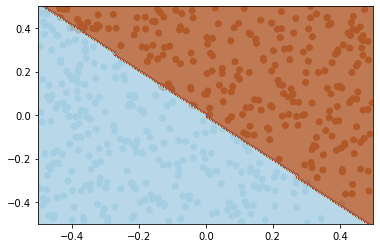

In [40]:
model_linear, acc = train_linear(data_linear, 0.01)
print('train acc {:.2f}'.format(acc))
draw_contour(model_linear, data_linear)

Does the model actually find a max margin boundary? Let's try a small training dataset where it's more visually clear. 

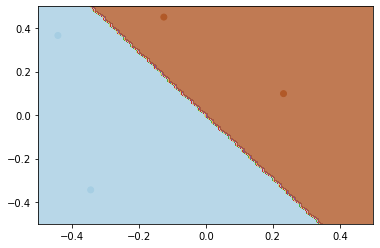

In [41]:
data_small = Data2D(4, boundary='line')
model_linear_small, _ = train_linear(data_small, 0.01)
draw_contour(model_linear_small, data_small)

It seems to. Just for fun, let's try fitting a linear SVM on the nonlinear data.

train acc 53.60


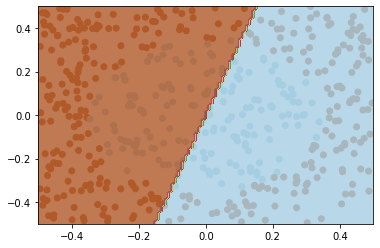

In [42]:
model_linear_bad, acc = train_linear(data_nonlinear, 0.01)
print('train acc {:.2f}'.format(acc))
draw_contour(model_linear_bad, data_nonlinear)

Not surprisingly, best line predictions are not much better than random guesses on the circle data.

# Kernel SVM

## Kernels

Let's start by implementing a few well-known kernels.

In [43]:
def construct_kernel(kernel_type, dim=1, offset=0., gamma=0.1):
  """
  Return a function that takes X (N, d) and Y (M, d) and outputs a (N, M) matrix 
  filled with kernel outputs.
  """
  if kernel_type == 'linear':
    def kernel(X, Y):
      return X.dot(Y.T)

  elif kernel_type == 'poly':
    def kernel(X, Y):
      return (offset + X.dot(Y.T)) ** dim

  elif kernel_type == 'gaussian':
    def kernel(X, Y):
      # Insert a new axis so that we can broadcast.
      X = X[:, np.newaxis, :]  # (N, 1, d)

      exponents = - gamma * (np.linalg.norm(X-Y, axis=2)**2)  # TODO: Implement.
      
      return np.exp(exponents)

  else:
    raise ValueError('Unknown kernel: ' + kernel)

  return kernel

## Model

A kernel SVM maintains $K$ support vectors $(x'_1, y'_1) \ldots (x'_K, y'_K)$ which is a subset of the training data. Training involves identifying the support vectors and learning their weights $\alpha_1 \ldots \alpha_K \geq 0$, which implies the parameter $w_{\mathrm{kernelized}} = \sum_{k=1}^K \alpha_k y'_k \phi(x'_k) \in \mathcal{F}$ where $\phi: \mathbb{R}^d \rightarrow \mathcal{F}$ is an implicit feature mapping under the chosen kernel. For any $x \in \mathbb{R}^d$, the model computes the score 
$$
w_{\mathrm{kernelized}} \cdot \phi(x) = \sum_{k=1}^K \alpha_k y'_k (\phi(x'_k) \cdot \phi(x)) = \sum_{k=1}^K \alpha_k y'_k K(x'_k, x)
$$

In [44]:
class KernelSVM:

  def __init__(self, dim, kernel):
    self.kernel = kernel
    self.support_X = np.zeros((1, dim))  # (K, d) where K is the number of support vectors
    self.support_y = np.zeros(1)  # K
    self.support_al = np.zeros(1)  # K

  def forward(self, X):
    kernel_output = self.kernel(self.support_X, X)  # (K, N)
    scores = (self.support_al * self.support_y).dot(kernel_output)  # N
    preds = 2 * (scores > 0) - 1  
    return {'preds': preds, 'scores': scores}

## Training

We will train a kernel SVM with the kernelized [Pegasos](https://home.ttic.edu/~nati/Publications/PegasosMPB.pdf) algorithm (see Fig. 3). It cleverly kernelizes the primal SVM objective optimized with SGD (with learning rate $\frac{1}{\lambda t}$) by noting that the parameter vector at update $t+1$ must always have the form 
$$
w^{(t+1)} = \frac{1}{\lambda t} \sum_{i=1}^N \textbf{count}(i) y_i \phi(x_i)
$$
where $\textbf{count}(i)$ is the number of times the margin constraint is violated on the $i$-th example so far. This implies that we never have to explicitly compute $w$; we can maintain examples with nonzero counts as support vectors and the counts as their weights ($\alpha$). 

In [45]:
def pegasos_kernelized(data, kernel, la, max_num_epochs=20, seed=42, verbose=False):
  set_seed(seed)
  model = KernelSVM(data.dim, kernel)
  violation_counts = np.zeros(data.num_examples)
  acc = 0.
  step = 1
  for epoch in range(1, max_num_epochs + 1):
    loss_total = 0.
    for (x, y, x_index) in data.generate_batch(1):
      output = model.forward(x)
      lr = 1 / (la * step)

      margin = lr * y * output['scores']  # TODO: Compute the margin (single example).

      if margin < 1:
      #   # TODO: Update the counts.
        violation_counts[x_index] += 1

      #   # TODO: Update the parameters (i.e., support vectors and their weights)
        if np.isin(model.support_X,x).any():
          model.support_al[np.where(np.isin(model.support_X,x))[0][0]] += 1;
        else:
          model.support_X = np.vstack((model.support_X, x))
          model.support_y = np.append(model.support_y, y)
          model.support_al = np.append(model.support_al, 1)

      step += 1

    acc = evaluate(model, data)
    if verbose:
      print('Epoch {:d}: train acc {:.2f}'.format(epoch, acc))    

  return model, acc

Can it fit nonlinear data? 

train acc 96.40


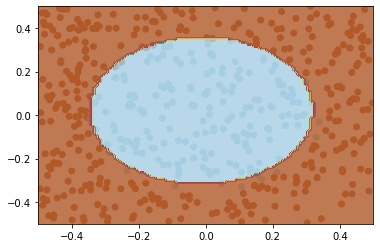

In [46]:
model_nonlinear, acc = pegasos_kernelized(data_nonlinear, construct_kernel('gaussian', gamma=0.5), 1e-4)
print('train acc {:.2f}'.format(acc))
draw_contour(model_nonlinear, data_nonlinear)

Apparently yes. It can also fit linear data, though it has more potential to overfit. 

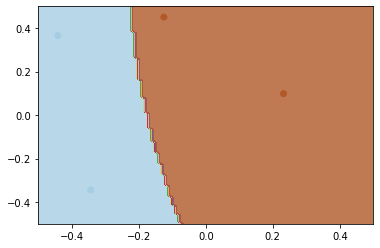

In [47]:
model_nonlinear_small, _ = pegasos_kernelized(data_small, construct_kernel('gaussian', gamma=0.5), 1e-4)
draw_contour(model_nonlinear_small, data_small)

# Twitter Sentiment Analysis


## Data

Now that our SVM is working on the toy dataset, let's do a simple sentiment analysis on [tweets on US airline service quality](https://www.kaggle.com/crowdflower/twitter-airline-sentiment/version/2). (WARNING: expletives unfiltered.) Download the data from [here](https://drive.google.com/drive/folders/1o3eBoB5Urj6Yf2UfHgOoDpzkv-DBp5jE?usp=sharing). We will assume that we have the directory `data/airline_tweets/` in our Google Drive account containing the provided data. 

In [48]:
# Load the Drive helper and mount. You will have to authorize this operation. 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The data is in the CSV format. The columns most relevant to our task are **airline_sentiment** and **text**.

In [49]:
import os
import pandas as pd

datadir = '/content/drive/My Drive/data/airline_tweets/'

dataframe_train = pd.read_csv(os.path.join(datadir, 'train.csv'))
dataframe_val = pd.read_csv(os.path.join(datadir, 'val.csv'))
dataframe_test = pd.read_csv(os.path.join(datadir, 'devtest.csv'))

print(dataframe_train.airline_sentiment.value_counts())
dataframe_train.head(3)

negative    5905
neutral     1804
positive    1442
Name: airline_sentiment, dtype: int64


,Unnamed: 0,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,3816,568103618500530176,neutral,1.0,NaN,NaN,United,NaN,willyvideo,NaN,0,@united #sfo #ClearVision #TV4U @ United Termi...,"[37.62006843, -122.38822083]",2015-02-18 09:43:52 -0800,NaN,Pacific Time (US & Canada)
1,10306,569379979055796224,negative,1.0,Customer Service Issue,0.6465,US Airways,NaN,PhilHagen,NaN,1,"@USAirways yes, i am as well. **FIVE** HOURS ...",NaN,2015-02-21 22:15:40 -0800,"Lewes, DE, USA",Eastern Time (US & Canada)
2,292,568840724700995584,negative,1.0,Flight Booking Problems,0.3895,Virgin America,NaN,notthatnathan,NaN,0,"@VirginAmerica Funny story, your website is br...",NaN,2015-02-20 10:32:51 -0800,"Portland, Maine",Eastern Time (US & Canada)


Note that the data is unbalanced, with significantly more negatives than neutral + positives (perhaps not surprisingly?). Therefore we group neutral and positive into one category and the final ratio of non-negative vs negative is about 1:2. This is consistent across train, val, and devtest.

## Data Preprocessing

We need to represent the data as a ($N \times d$) matrix, but what we have on our hands is unstructured text. The simplest solution to transform an airline review into a vector is [bag of words](https://en.wikipedia.org/wiki/Bag-of-words_model). We maintain a global vocabulary of word patterns gathered from our corpus, with single words such as "great", "horrible", and optionally consecutive words ($n$-grams) like "friendly service", "luggage lost". Suppose we have already collected a total of 10000 such patterns, to transform a sentence into a 10000-dimensional vector, we simply scan it and look for the patterns that appear and set their correponding entries to 1 and leave the rest at 0. What we end up with is a sparse vector that can be fed into SVMs. For this exercise we use the basic text processing routines in nltk and sklearn.

In [50]:
import re, nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [51]:
stop_words = set(stopwords.words('english'))  # Try printing out stop words. 
wordnet_lemmatizer = WordNetLemmatizer()

def tokenize_normalize(tweet):
  only_letters = re.sub('[^a-zA-Z]', ' ', tweet)
  tokens = nltk.word_tokenize(only_letters)[2:]
  lower_case = [l.lower() for l in tokens]
  filtered_result = list(filter(lambda l: l not in stop_words, lower_case))
  lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result]
  return lemmas

print(dataframe_train.text[1])
print(tokenize_normalize(dataframe_train.text[1]))

@USAirways yes, i am as well.  **FIVE** HOURS ON HOLD, FOLKS. Can you PLEASE tell me if this is typical?! Trying to be understanding here.
['well', 'five', 'hour', 'hold', 'folk', 'please', 'tell', 'typical', 'trying', 'understanding']


We'll use [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) in sklearn to scan our corpus, build the vocab, and change text into vectors. You can try 2-grams (aka. bigrams), but that'll make the vocab much larger. 

In [52]:
vectorizer = CountVectorizer(tokenizer=tokenize_normalize, token_pattern=None, 
                             strip_accents='unicode', ngram_range=(1, 1))  
# Extract the vocabulary
vectorizer.fit(pd.concat([dataframe_train, dataframe_val, dataframe_test]).text)  

# Take a peek at the vocabulary. We have the terms and the counts
print(list(vectorizer.vocabulary_.items())[:10])
print('Vocabulary size: {:d}'.format(len(vectorizer.vocabulary_)))

[('clearvision', 1531), ('tv', 9169), ('u', 9210), ('united', 9315), ('terminal', 8765), ('sfo', 7920), ('airport', 209), ('http', 4111), ('co', 1582), ('q', 7009)]
Vocabulary size: 10250


Note that the input dimension is fairly large (=vocabulary size). Coming up with a manageable vector representation is a major topic in natural language processing.

In [53]:
class DataTwitter(Data):

  def __init__(self, dataframe, vectorizer):
    self.inputs = vectorizer.transform(dataframe.text).toarray()

    # Convert 'positive', 'neutral' to +1 and 'negative' to -1.
    sentiments = dataframe['airline_sentiment'].tolist()
    self.labels = np.array([-1 if sentiment == 'negative' else 1 for sentiment in sentiments])
    (self.num_examples, self.dim) = self.inputs.shape

In [54]:
data_twitter_train = DataTwitter(dataframe_train, vectorizer)
data_twitter_val = DataTwitter(dataframe_val, vectorizer)
data_twitter_test = DataTwitter(dataframe_test, vectorizer)
print('Train data shape: {:d} x {:d}'.format(data_twitter_train.num_examples, data_twitter_train.dim))
print('Val data shape: {:d} x {:d}'.format(data_twitter_val.num_examples, data_twitter_val.dim))
print('Test data shape: {:d} x {:d}'.format(data_twitter_test.num_examples, data_twitter_test.dim))

Train data shape: 9151 x 10250
Val data shape: 1016 x 10250
Test data shape: 984 x 10250


In [56]:
# Train Linear SVM on Twitter Data
modelOrig, acc_trainOrig = train_linear(data_twitter_train, 0.01)
acc_valOrig = evaluate(modelOrig, data_twitter_val)
print('Base Model: Training Accuracy {:.2f}\t Validation Accuracy {:2.2f}'.format(acc_trainOrig, acc_valOrig))

Base Model: Training Accuracy 79.07	 Validation Accuracy 77.17


In [61]:
# Hyperparameter Tuning on Validation Set
model_best = None
best_acc_val = float('-inf')
# for la in [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5]:
for la in [0.00001, 0.00005, 0.0001, 0.0005, 0.001]:
  for epochs in [30, 45, 60]:
    model, acc_train = train_linear(data_twitter_train, la, epochs)
    acc_val = evaluate(model, data_twitter_val)
    acc_test = evaluate(model, data_twitter_test)
    print('la {:10.4f}\t epochs {:10.4f}\t acc train {:2.2f}\t acc val {:2.2f}\t test acc {:2.2f}'.format(la, epochs, acc_train, acc_val, acc_test))
    if acc_val > best_acc_val:
      best_acc_val = acc_val
      model_best = copy.deepcopy(model)

print('Best Model Validation Acc {:.2f}'.format(best_acc_val))

la     0.0000	 epochs    30.0000	 acc train 95.24	 acc val 76.18	 test acc 75.10
la     0.0000	 epochs    45.0000	 acc train 96.22	 acc val 77.07	 test acc 77.44
la     0.0000	 epochs    60.0000	 acc train 96.24	 acc val 76.48	 test acc 77.74
la     0.0001	 epochs    30.0000	 acc train 95.26	 acc val 77.07	 test acc 77.34
la     0.0001	 epochs    45.0000	 acc train 95.40	 acc val 77.26	 test acc 78.66
la     0.0001	 epochs    60.0000	 acc train 95.17	 acc val 78.35	 test acc 78.05
la     0.0001	 epochs    30.0000	 acc train 94.20	 acc val 77.26	 test acc 78.76
la     0.0001	 epochs    45.0000	 acc train 94.25	 acc val 78.94	 test acc 78.86
la     0.0001	 epochs    60.0000	 acc train 94.20	 acc val 78.94	 test acc 78.96
la     0.0005	 epochs    30.0000	 acc train 90.39	 acc val 80.41	 test acc 78.35
la     0.0005	 epochs    45.0000	 acc train 90.30	 acc val 80.51	 test acc 78.35
la     0.0005	 epochs    60.0000	 acc train 90.26	 acc val 80.41	 test acc 78.46
la     0.0010	 epochs    30.

In [ ]:
# Testing the best model from the hypertuning above
acc_test = evaluate(model_best, data_twitter_test)
print('Best Model Final Test Acc {:.2f}'.format(acc_test))

Best Model Final Test Acc 78.66


## Experiments
Train a linear SVM on the twitter sentiment data. Play around with different parameter settings (e.g., number of epochs, regularization strength) and find the best setting on the validation set, then evaluate on the devtest set when you're finished tuning. 

**1. What is your best *val* performance? Also report what hyperparameter values you used.**
The best val performance I ran got a accuracy score of 80.71. The hyperparameters I used were a lamda value of 0.0005 and 50 epochs.

**2. What is your final *test* performance, using your single best model? Do you see a large gap between the validation and test accuracies?**
The final test performance using the best model got an accuracy score of 78.96. There was very clearly a large gap between the val accuracy score and the test accuracy score. Although the actual gap itself is only a few numbers apart, I consider it a big gap because there were numerous other hyperparameters that did better or fell within the gap. If I were to guess, I would say that the reason for the gap would be because the model was overfitting during the hyperparameter tuning.


Feel free to explore and discuss additional results. For instance,

- (Optional) Try to come up with a better text feature representation. We threw out all the emojis. >_< what a waste
- (Optional) Experiment with kernel SVM. Given the high feature dimensionality of our primitive text processing, we do not recommend using kernel SVM here. It could take a long time to train. If you reduce the feature dimensionality, then it's a different story. Alternatively you could try to improve the efficiency of the Pegasos implementation: the current implementation is pretty dumb since it completely rewrites support vectors and weights at every iteration which is almost certainly not necessary. 